# Generate LPCs From Audio Files

In [215]:
import librosa
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

## 1) Declare Audio Processing Constants

In [216]:
# Number of LPC Coefficients to Model
NUM_LPC = 14

# Sample Rate is 44.1 kHz
RECORDED_SAMPLE_RATE = 44100

# Desired Sample Rate for LPC Processing is 14 kHz
DESIRED_SAMPLE_RATE = NUM_LPC * 1000

# Front and Back Vowels
FRONT_VOWELS = ["iy", "ih", "eh"]
BACK_VOWELS = ["uw", "ow", "aa"]

# Wav File Directory
WAV_FILE_DIRECTORY = "./wav_data/"

# Unit Convsersions
SEC_TO_MS = 1/1000

## 2) Helper Functions

### 2a) Load Audio and Preprocess Audio
1. Downsampling 44kHz to 14kHz (1kHz per LPC Value)
2. Use a High Frequency Heuristic

In [217]:
# ./wav_data/vowels_Maria/aa_maria.wav
def process_audio(path_to_audio_file: str, NUM_MS=50, HIGH_FREQUENCY_HEURISTIC=True) -> np.ndarray:
    """
    Processes an audio file by loading it into a numpy array
    and changing the sample rate to NUM_LPC * 1000 and slicing out 
    NUM_MS (number of miliseconds) before and after the file midpoint. 
        Note: There will be NUM_MS*2 ms worth of sampling

    Additionally, there is a heuristic for adding back frequencies
    using a simple `diff` of consecutive elements which can
    be disabled using the HIGH_FREQUENCY_HEURISTIC flag.

    Parameters
    ----------
    path_to_audio_file : str
        Path to the audio input file

    HIGH_FREQUENCY_HEURISTIC : bool
        Whether or not to use transform the audio file into a difference
        of consecutive samples. a[i] = a[i+1] - a[i] 

    Returns
    --------
    audio_array : np.ndarray
        processed audio file as a numpy array
    """

    # Step 1) Load in Raw Audio
    audio_file, _ = librosa.load(
        path=path_to_audio_file,
        sr=RECORDED_SAMPLE_RATE
    )

    # Step 2) Take only the samples NUM_SEC ms before and after the midpoint of the file
    file_middle_idx = len(audio_file) // 2
    num_samples = int(NUM_MS * SEC_TO_MS * RECORDED_SAMPLE_RATE)
        # Note: Sample rate is in Hz or (samples/sec), so we get # of samples from `ms * (sec/ms) * (samples/sec)`
    middle_audio_only = audio_file[
        file_middle_idx - num_samples:
        file_middle_idx + num_samples
    ]

    # Step 3) Change sample rate
    down_sampled_audio_file = librosa.resample(
        middle_audio_only,
        orig_sr=RECORDED_SAMPLE_RATE,
        target_sr=DESIRED_SAMPLE_RATE
    )

    # Step 4) Rentroduce high frequencies if needed
    if (HIGH_FREQUENCY_HEURISTIC):
        down_sampled_audio_file = np.diff(down_sampled_audio_file)

    return down_sampled_audio_file

### 2b) Cohen's D
- Calculate the effect size between 2 given LPC Coefficients

#### Cohen's D Intuition
- Cohen's D = measure of the `average difference` between 2 datasets and how prominent that variation is
- The lower the `normalized_variance` the more impactful the `mean_difference` is

#### Cohen's D Calculation
- Cohen's D = `mean_difference` / `normalized_variance`
- let `mean_difference` = avg(`dataset1's LPC Coefficient X`) - avg(`dataset2's LPC Coefficient X`)
- let `normalized_variance` = sqrt(`variance`) / 2
- let `variance` = std(`dataset1's LPC Coefficient X`)^2 - std(`dataset2's LPC Coefficient X`)^2

#### Cohen's D Ranges

| Effect Size | `Cohen's D` Value |
| ----------- | ----------------- |
| Small       | <= 0.2            |
| Medium      | <= 0.5            |
| Large       | >= 0.8            |

In [218]:
def calculate_cohens_d(lpc_x_dataset1: np.array, lpc_x_dataset2: np.array) -> tuple[np.float32, str]:
    """
    Compare the effect size of dataset1's and dataset2's LPC_X where
    X is an arbitrary LPC Coefficient

    Parameters
    ----------
    lpc_x_dataset1 : np.array
        The Xth LPC coefficients for every sample in dataset 1
            ex: LPC 12 for all `front vowels`
    
    lpc_x_dataset2 : np.array
        The Xth LPC coefficients for every sample in dataset 2
            ex: LPC 12 for all `front vowels`
    
    Note: Both datasets should be have the same LPC index

    Returns
    --------
    cohens_d : np.float64
        Cohen's D or Effect Size of LPC Index X with respect to dataset 1 and dataset 2
            ex: How likely the difference between LPC X in dataset 1 and dataset 2 
                is to be noticeable in an experiment/real life scenario

    label: str
        Returns whether the effect size is Small, Medium, or Large
    """

    assert len(lpc_x_dataset1) > 1, "lpc_x_dataset1 must have more than 1 number" 
    assert len(lpc_x_dataset1) > 1, "lpc_x_dataset2 must have more than 1 number" 

    # Step 1) Numerator = Mean Difference
    mean_difference = np.mean(lpc_x_dataset1) - np.mean(lpc_x_dataset2)
    
    # Step 2) Get the total variance of both datasets
    total_variance = np.std(lpc_x_dataset1)**2 + np.std(lpc_x_dataset2)**2

    # Step 3) Normalize the Variance
    normalized_variance = np.sqrt(total_variance) / 2

    # Step 4) Calculate effect size
    cohens_d = mean_difference / normalized_variance

    # Step 5) Get the label according to Cohen's D
    label = ""
    if(cohens_d <= 2.0):
        label = "Small"
    elif(cohens_d <= 5.0):
        label = "Medium"
    else:
        label = "Large"

    return cohens_d, label

### 2c) Vowel Lists
- Get all files of a specific vowel type
-   Note: This relies on a naming convention where all files belong to `./wav_data` and have the vowel name in their filename:
-   ex: `./wav_data/*/iy*.wav`

In [219]:
def get_all_wavs_audio(WAV_DATA_PATH: str, VOWEL_LIST: list[str]) -> tuple[list[np.ndarray], list[str]]: 
    """
    Returns (1) a list of processed audio files and (2) its corresponding path 
    which have a match in `VOWEL_LIST`.

    Parameters
    ----------
    WAV_DATA_PATH : str
        The root path to the wav data, need not be in this repository.
    
    VOWEL_LIST : list[str]
        A list of vowels which should be included in the all_paths. Used for 
        string matching.

    Returns
    --------
    all_paths : list[np.array]
        an array of audio files processed using the `process_audio` function

    all_paths : list[str]
        an array where each index is the relative path to the wav file  
    """

    # Step 1) Get path to all subfolders where the wav files live    
    all_paths = []

    for vowel in VOWEL_LIST:
        # Note: ** means a recursive search using the `glob`al search library
        path_to_vowel = os.path.join(WAV_DATA_PATH, '**', vowel)
        all_paths += glob.glob(f"{path_to_vowel}*.wav")
    
    # Step 2) Convert each wav file to an audio file
    all_audio = []
    for path in all_paths:
        audio_file = process_audio(path_to_audio_file=path)
        all_audio.append(audio_file)

    # Step 2) Return all paths
    return all_audio, all_paths

### 2d) Aggregate LPC values

## 3) Generate All LPC Data

In [220]:
# Step 1) Load in data for Front and Back Vowels
front_vowel_audio, _ = get_all_wavs_audio(WAV_DATA_PATH=WAV_FILE_DIRECTORY, VOWEL_LIST=FRONT_VOWELS)
back_vowel_audio, _ = get_all_wavs_audio(WAV_DATA_PATH=WAV_FILE_DIRECTORY, VOWEL_LIST=BACK_VOWELS)

# Step 2) Generate LPCs for each data set 
lpc_front_vowels = aggregate_lpc(front_vowel_audio, NUM_LPC=NUM_LPC)
lpc_back_vowels = aggregate_lpc(back_vowel_audio, NUM_LPC=NUM_LPC)

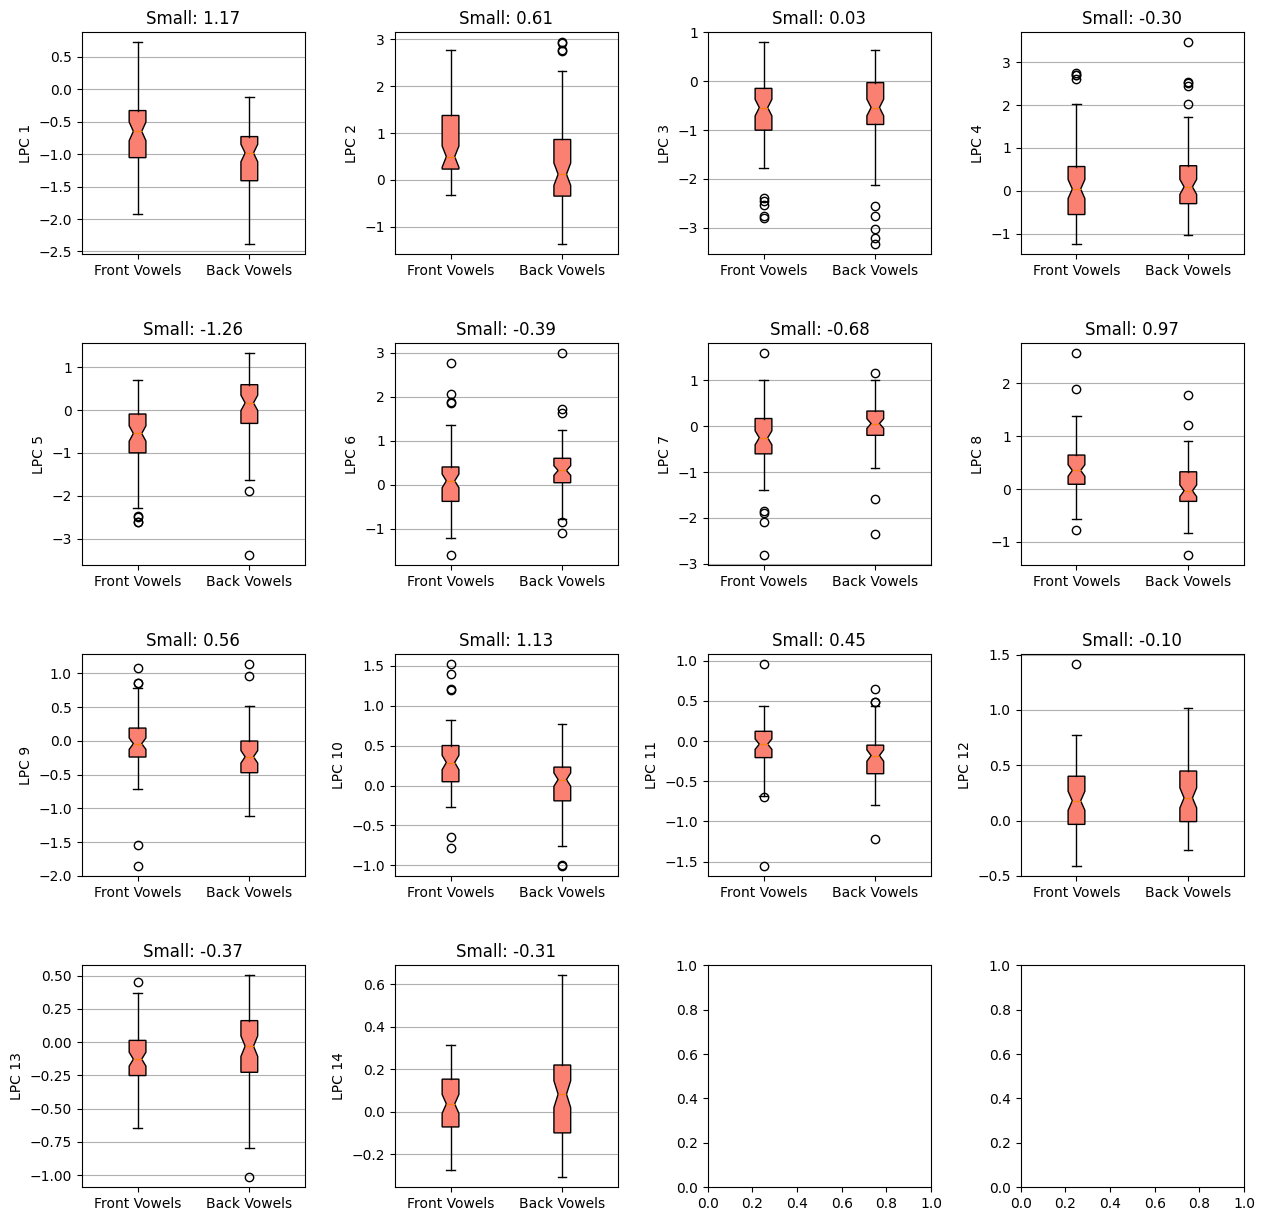

In [236]:
# Step 3) Plot Each LPC Value

# Format an evenly spaced 15in x 15in figure with 4 rows and 4 columns
plt.rcParams['figure.figsize'] = (15, 15)
fig, axes = plt.subplots(nrows=4, ncols=4)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(NUM_LPC):
    # Fromat Cohen's D Value
    cohens_d_value, cohens_d_label = calculate_cohens_d(
        lpc_x_dataset1=lpc_front_vowels[:, i],
        lpc_x_dataset2=lpc_back_vowels[:, i]
    )
    cohens_d_value = "{:.2f}".format(cohens_d_value, decimal=5)
    formatted_cohens_d_title = f"{cohens_d_label}: {cohens_d_value}"

    cur_axis = axes[i//4][i % 4]
    cur_axis.set_title(formatted_cohens_d_title)
    cur_axis.set_ylabel(f"LPC {i+1}")
    cur_axis.yaxis.grid(True)
    a = cur_axis.boxplot(
        [lpc_front_vowels[:, i], lpc_back_vowels[:, i]],
        labels=["Front Vowels", "Back Vowels"],
        boxprops=dict(facecolor="salmon"),
        notch=True,  # notch shape
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
    )